# Simple Video Game Exploration & Prediction

## Introduction

In this notebook kernel we are going to be looking at the dataset of video game sales from the 1990's to the current years of the 2016.

The purpose of exploring this data is to observe trends and habits that seem to be present in game sales over a period of time. With this data we are attempying to make prediction on future game sales. Although this dataset is older we can actively see if the predictions are right with what is now on the market in the current day. Of course, this does not account for new consoles released in the past few years, as capturing accurate data on game sales for modern and upcoming systems has become increasingly challenging.

The plan to achieve our objective involves several key steps: conducting data exploration and processing using the DecisionTreeRegressor, RandomForestRegressor, and XGBRegressor models.After performing cross-validation to ensure the accuracy of our chosen model, will we be able to make our predictions about the future trajectory of video game sales.

## The Data

##### Import important libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import os
from sklearn.model_selection import(
    train_test_split,
    TimeSeriesSplit,
    KFold,
    StratifiedGroupKFold,  # can prob take these extra split methods away since it seems we only use KFold
    GroupKFold,
    StratifiedKFold,
)
from matplotlib.patches import Patch

In [2]:
vgsales = pd.read_csv("vgsales.csv")
vgsales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


Luckily our data we have is extremely uniform, with many of the columns having almost the exact same amount of values except for the Year and Publisher columns. 

In [3]:
vgsales.columns.tolist()

['Rank',
 'Name',
 'Platform',
 'Year',
 'Genre',
 'Publisher',
 'NA_Sales',
 'EU_Sales',
 'JP_Sales',
 'Other_Sales',
 'Global_Sales']

We get 11 columns to mess with in this dataset:
- **Rank**: This is the rank of the game in descending order of the most Global Sales

- **Name**: The name of the game or franchise

- **Platform**: The platform the game was released on (since there are games that came out on multiple platforms there will be mild duplicates)

- **Year**: release year for the game

- **Genre**: The genre of the game

- **Publisher**: The publisher of the game

- **NA_Sales**: Number of copies sold in America

- **EU_Sales**: Number of copies sold in Europe

- **JP_Sales**: Number of copies sold in Japan

- **Other_Sales**: Sales in places that are not in America, Europe, nor Japan

- **Global Sales**: These are the combined sales for all of the regions

Since the dataset comes with these, we will not be changing the naming of them in our analysis

##### Quick look at the data

In [4]:
#A quick look at the head 
vgsales.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [5]:
# A quick look at the tail
vgsales.tail()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
16593,16596,Woody Woodpecker in Crazy Castle 5,GBA,2002.0,Platform,Kemco,0.01,0.00,0.0,0.0,0.01
16594,16597,Men in Black II: Alien Escape,GC,2003.0,Shooter,Infogrames,0.01,0.00,0.0,0.0,0.01
16595,16598,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,Activision,0.00,0.00,0.0,0.0,0.01
16596,16599,Know How 2,DS,2010.0,Puzzle,7G//AMES,0.00,0.01,0.0,0.0,0.01
16597,16600,Spirits & Spells,GBA,2003.0,Platform,Wanadoo,0.01,0.00,0.0,0.0,0.01


In [6]:
# A quick look at some random data
vgsales.sample(20)

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
14071,14073,Planescape: Torment,PC,1998.0,Role-Playing,Interplay,0.01,0.02,0.00,0.01,0.04
10834,10836,Barnyard,PS2,2006.0,Action,THQ,0.05,0.04,0.00,0.01,0.09
7646,7648,From Russia With Love,XB,2005.0,Action,Electronic Arts,0.15,0.04,0.00,0.01,0.20
8076,8078,Vampire Savior: The Lord of Vampire,SAT,1998.0,Fighting,Capcom,0.00,0.00,0.18,0.00,0.18
12324,12326,GunGriffon II,SAT,1998.0,Simulation,ESP,0.00,0.00,0.06,0.00,0.06
12617,12619,Raw Danger! (JP sales),PS2,2006.0,Action,505 Games,0.00,0.00,0.06,0.00,0.06
8212,8214,Army Men: Sarge's Heroes 2,PS2,2001.0,Shooter,Midas Interactive Entertainment,0.09,0.07,0.00,0.02,0.17
7345,7347,Wild Wild Racing,PS2,2000.0,Racing,Interplay,0.10,0.08,0.00,0.03,0.21
16104,16107,Barbie and Her Sisters Puppy Rescue,WiiU,2015.0,Action,Namco Bandai Games,0.00,0.01,0.00,0.00,0.01
11648,11650,Super Robot Taisen Z Special Disc,PS2,2009.0,Misc,Namco Bandai Games,0.00,0.00,0.08,0.00,0.08


### Data Cleaning 

Since our data is relatively complete, we only need to do a small amount of cleaning of the data, such as missing Year and Publisher Values.

##### Inspecting missing values

In [7]:
null_years = vgsales[vgsales['Year'].isnull()]
null_years.info()

<class 'pandas.core.frame.DataFrame'>
Index: 271 entries, 179 to 16493
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          271 non-null    int64  
 1   Name          271 non-null    object 
 2   Platform      271 non-null    object 
 3   Year          0 non-null      float64
 4   Genre         271 non-null    object 
 5   Publisher     249 non-null    object 
 6   NA_Sales      271 non-null    float64
 7   EU_Sales      271 non-null    float64
 8   JP_Sales      271 non-null    float64
 9   Other_Sales   271 non-null    float64
 10  Global_Sales  271 non-null    float64
dtypes: float64(6), int64(1), object(4)
memory usage: 25.4+ KB


In [8]:
null_publishers = vgsales[vgsales['Publisher'].isnull()]
null_publishers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58 entries, 470 to 16553
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          58 non-null     int64  
 1   Name          58 non-null     object 
 2   Platform      58 non-null     object 
 3   Year          36 non-null     float64
 4   Genre         58 non-null     object 
 5   Publisher     0 non-null      object 
 6   NA_Sales      58 non-null     float64
 7   EU_Sales      58 non-null     float64
 8   JP_Sales      58 non-null     float64
 9   Other_Sales   58 non-null     float64
 10  Global_Sales  58 non-null     float64
dtypes: float64(6), int64(1), object(4)
memory usage: 5.4+ KB


Null Publishers will be filled with 'Unknown' and missing years will be filled with the median year (a good inbetween). Doing this will help in preserving valuable sales data that is still attached to these missing instances.


In [9]:
# Replace Null with Unknown 
vgsales['Publisher'] = vgsales['Publisher'].fillna('Unknown')

# Replace Null Years with median year
middle_years = vgsales['Year'].median()
vgsales['Year'] = vgsales['Year'].fillna(middle_years)
vgsales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16598 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16598 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


With filling in those values our datset is now full with values

## Data Exploration

With our data exploration we are simply going to look at how all of the game sales compared at the time. 

Examples like: 

- What are the global sales over time? 

- What Genre sold the best overall? 

- What Genre was most popular each year? 

- Which Genre and Platforms were received the best according to region? 

- What Platform performed the best overall?  

- What game sold the best each year? 

- What are the most grossed video games overall? 

- Which platform sold the most per year and how much? 

- Of the Top 10 Platforms, how many games did each release total? 

- Who are the top selling Publishers per year? And overall? 

- What was the best genre on each platform?

### Year Sales

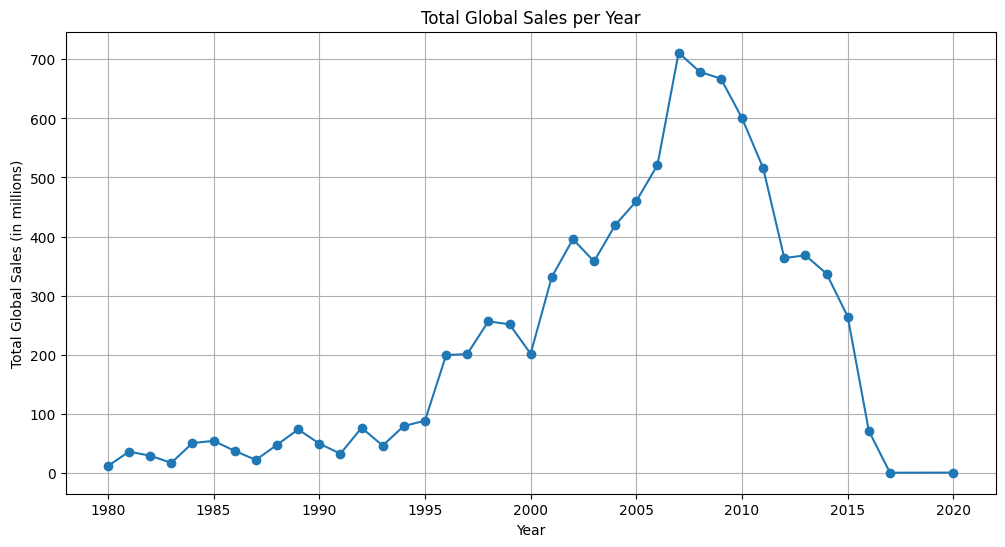

In [10]:
# Aggregate moment
global_sales_per_year = vgsales.groupby('Year')['Global_Sales'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(global_sales_per_year['Year'], global_sales_per_year['Global_Sales'], marker='o')
plt.title('Total Global Sales per Year')
plt.xlabel('Year')
plt.ylabel('Total Global Sales (in millions)')
plt.grid(True)
plt.show()


Looking at this chart tells us that around the year 1995 there was a dramatic increase in the amount of games that were being sold. Once we hit 2007 or so there is a noticaeble peak and since then been on a decline. This year is around the time when consoles like the Wii, Ps3, and Xbox360 were dominant. 

However it should be duly noted that VGChartz they stopped producing estimates of software sales by 2018. This was due to the increasing dominance of digital downloads and purchases, a far more complex process. Digital download and purchase of video games first presented itself in the early 2000s, and slowly took off flight when platforms like Steam got introduced. All seems to be reflected in this graph, including the shortcoming of being able to keep up with video game sales accuracy. 

### Genre Sales

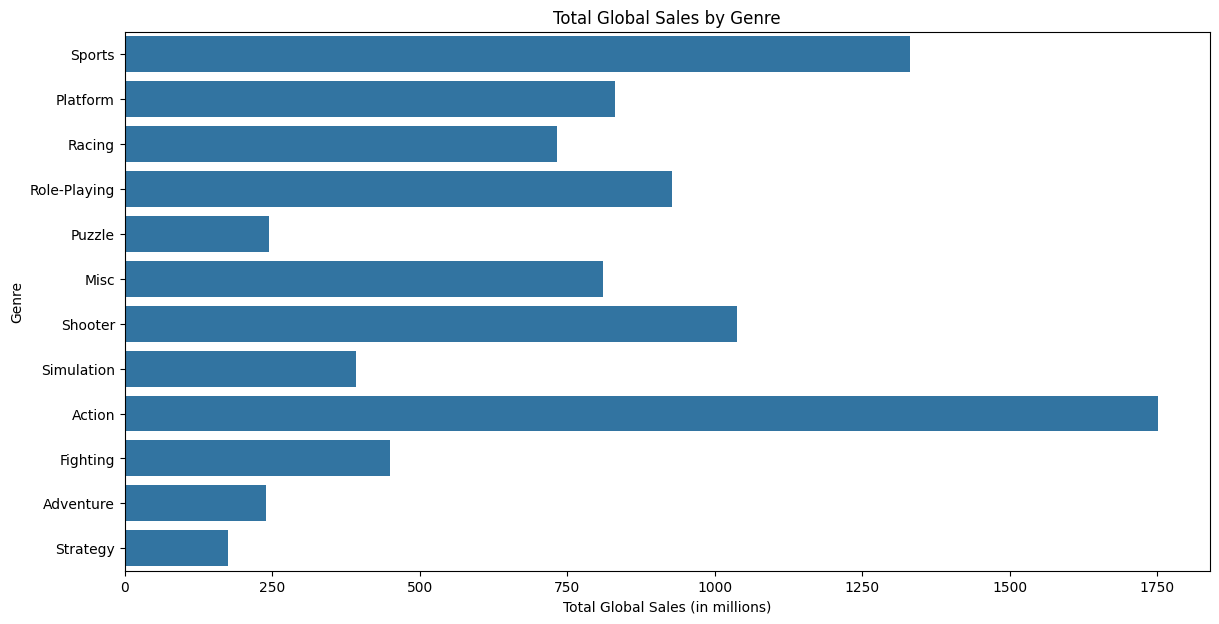

In [11]:
# Sales by Genre
plt.figure(figsize=(14, 7))
sns.barplot(x='Global_Sales', y='Genre', data=vgsales, estimator=sum, errorbar=None)
plt.title('Total Global Sales by Genre')
plt.xlabel('Total Global Sales (in millions)')
plt.ylabel('Genre')
plt.show()

With this graph we can see that Action Games are certainly the most liked genre with them having 1750 million sales globally with Sports following behind with over 1250 million sales

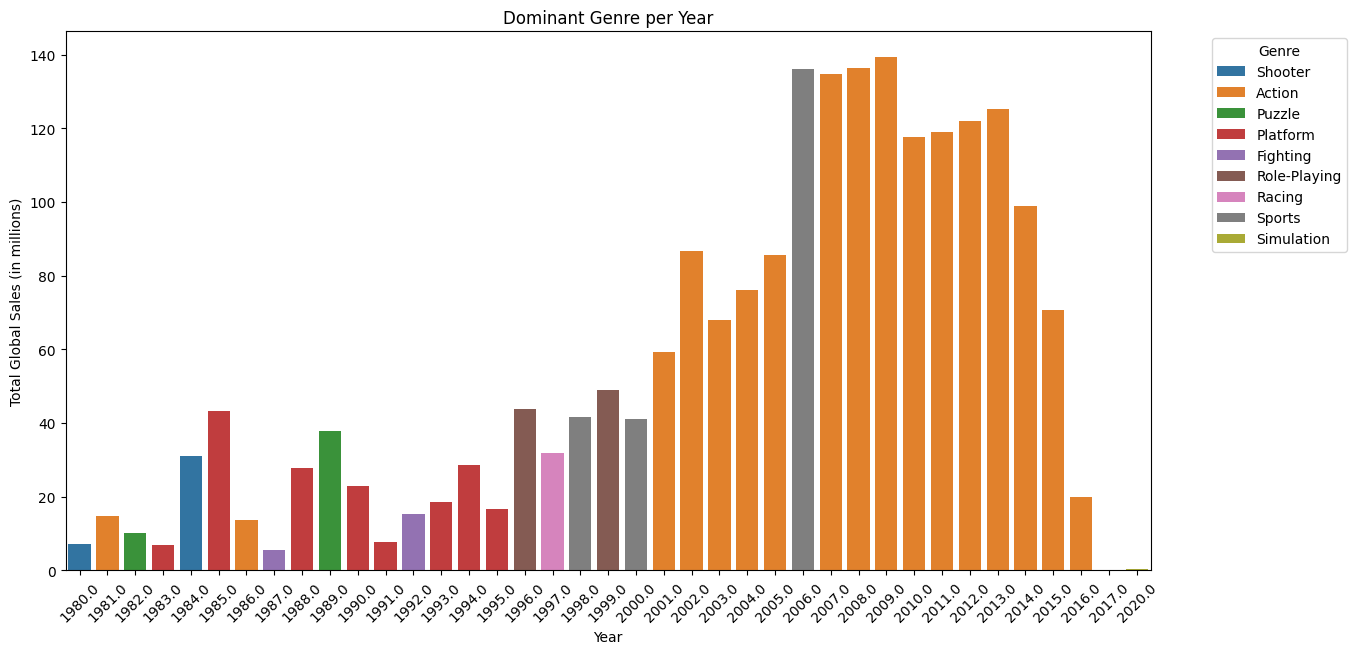

In [12]:
year_genre_sales = vgsales.groupby(['Year', 'Genre'])['Global_Sales'].sum().reset_index()

dominant_genres_per_year = year_genre_sales.loc[year_genre_sales.groupby('Year')['Global_Sales'].idxmax()]

plt.figure(figsize=(14, 7))
sns.barplot(x='Year', y='Global_Sales', hue='Genre', data=dominant_genres_per_year, dodge=False)
plt.title('Dominant Genre per Year')
plt.xlabel('Year')
plt.ylabel('Total Global Sales (in millions)')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()


With knowing that around 1995 is where the gaming sales kicked off, we can see even in this chart, shortly after game sales started to increase rapidly, Action games quickly took over the top ranks.

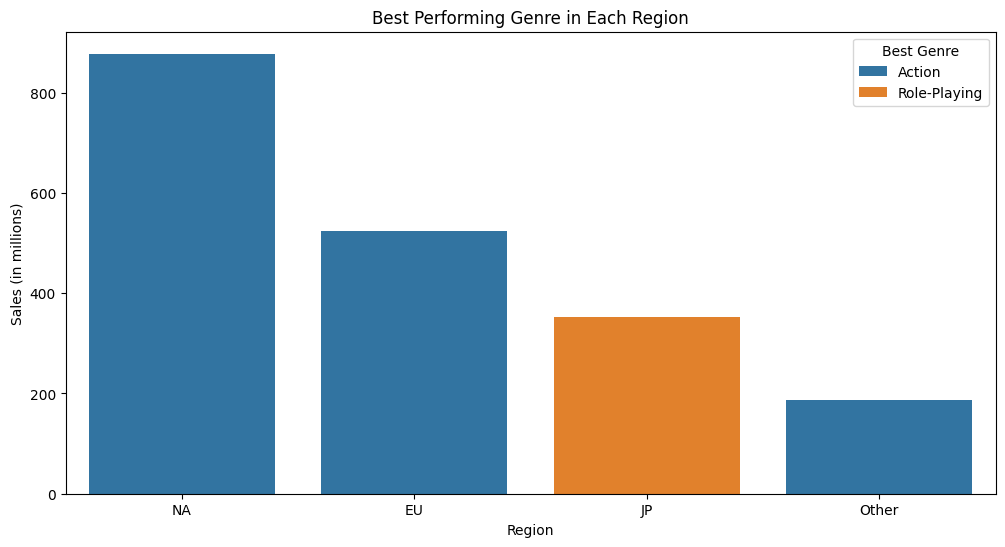

In [13]:
genre_sales = vgsales.groupby('Genre').sum()[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].reset_index()

top_genre_na = genre_sales.loc[genre_sales['NA_Sales'].idxmax()]
top_genre_eu = genre_sales.loc[genre_sales['EU_Sales'].idxmax()]
top_genre_jp = genre_sales.loc[genre_sales['JP_Sales'].idxmax()]
top_genre_other = genre_sales.loc[genre_sales['Other_Sales'].idxmax()]

best_genres = pd.DataFrame({
    'Region': ['NA', 'EU', 'JP', 'Other'],
    'Best_Genre': [top_genre_na['Genre'], top_genre_eu['Genre'], top_genre_jp['Genre'], top_genre_other['Genre']],
    'Sales': [top_genre_na['NA_Sales'], top_genre_eu['EU_Sales'], top_genre_jp['JP_Sales'], top_genre_other['Other_Sales']]
})

# Plot the results
plt.figure(figsize=(12, 6))
sns.barplot(x='Region', y='Sales', hue='Best_Genre', data=best_genres, dodge=False)
plt.title('Best Performing Genre in Each Region')
plt.xlabel('Region')
plt.ylabel('Sales (in millions)')
plt.legend(title='Best Genre')
plt.show()


While the Action Genre is the best selling overall, the only place it doesnt seem to fully dominate is Japan with Role-Playing games taking up that role instead.

### Platform

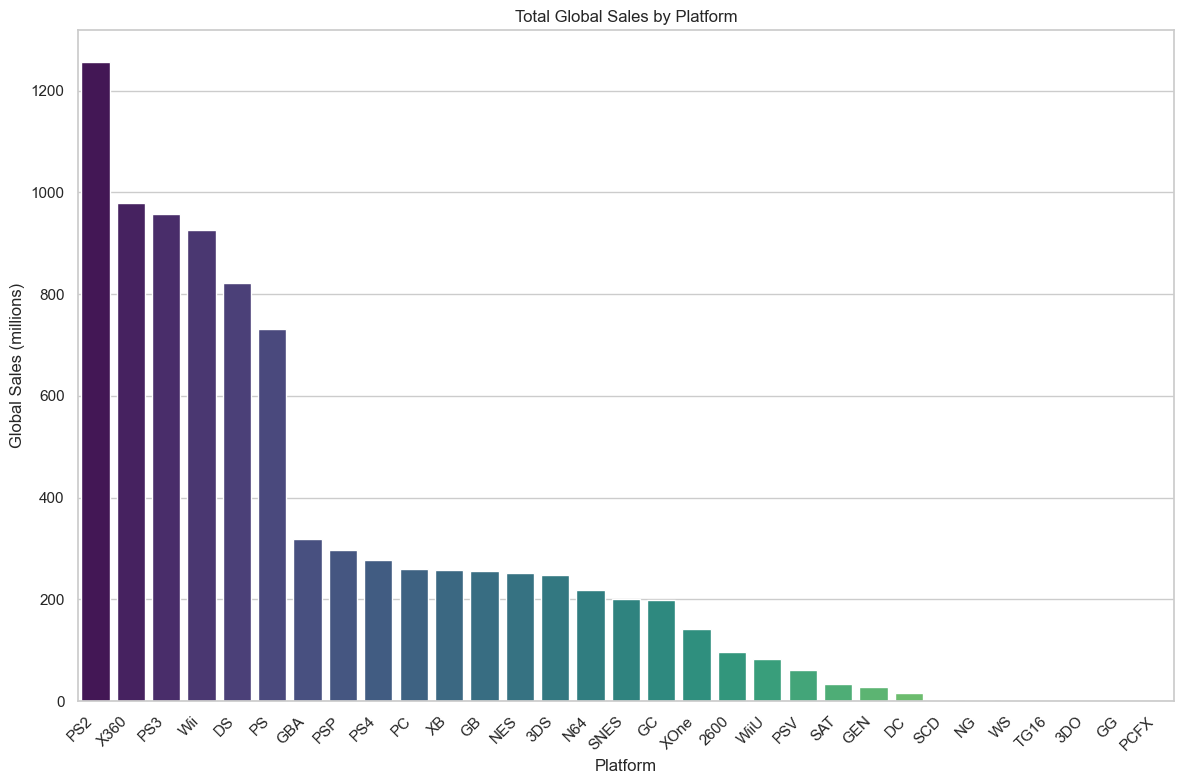

In [14]:
# Group by Platform, summing up Global_Sales
platform_sales_total = vgsales.groupby('Platform')['Global_Sales'].sum().reset_index()
# Sort platforms by total global sales in descending order
platform_sales_total_sorted = platform_sales_total.sort_values(by='Global_Sales', ascending=False)

# Set up the plot
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

# Plotting
sns.barplot(data=platform_sales_total_sorted, x='Platform', y='Global_Sales', palette='viridis', hue='Platform', legend=False)

# Adding labels and title
plt.title('Total Global Sales by Platform')
plt.xlabel('Platform')
plt.ylabel('Global Sales (millions)')
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()


In this graph is noticeable taht PS2 is the top selling platform among all others, surpassing 1.2 billion in sales.

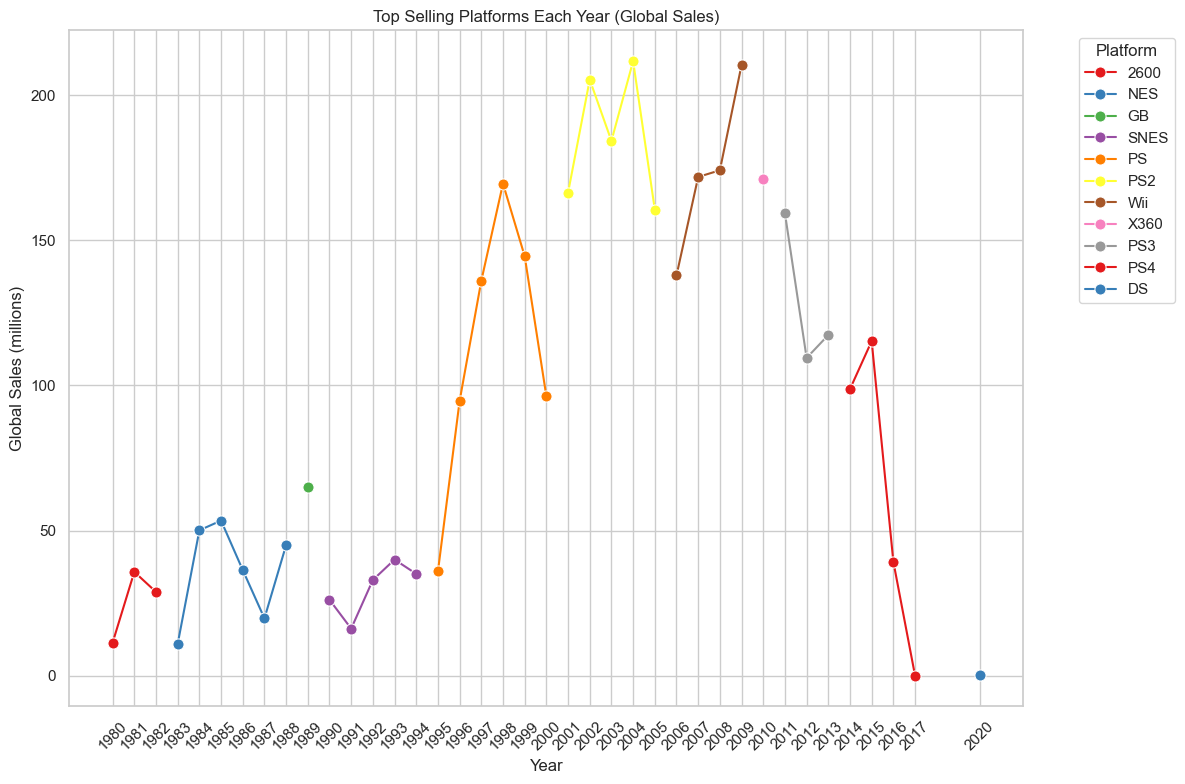

In [15]:
# Group by Year and Platform, summing up Global_Sales
platform_sales_year = vgsales.groupby(['Year', 'Platform'])['Global_Sales'].sum().reset_index()

# Find the top selling platform for each year
top_platforms_year = platform_sales_year.loc[platform_sales_year.groupby('Year')['Global_Sales'].idxmax()]

# Sort the top platforms by year for better plotting
top_platforms_year_sorted = top_platforms_year.sort_values(by='Year')

# Set up the plot
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")  # Optional: Use seaborn styling

# Plotting
sns.lineplot(data=top_platforms_year_sorted, x='Year', y='Global_Sales', hue='Platform', marker='o', markersize=8, palette='Set1')

# Adding labels and title
plt.title('Top Selling Platforms Each Year (Global Sales)')
plt.xlabel('Year')
plt.ylabel('Global Sales (millions)')
plt.xticks(top_platforms_year_sorted['Year'].unique())
plt.xticks(rotation=45)


# Display the plot
plt.legend(title='Platform', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

However when looking at this graph immediately afterwards, we can see that PS2 only dominated from the years 2000 to 2005, after which the Wii took over. This graph goes on to show how the introduction of a new console could very possibly dominate in sales for the years that it is relevant. Due to the fact that we don't have data on the more recent platforms, it is very possible that PS2 has been surpassed when it comes to total global sales.

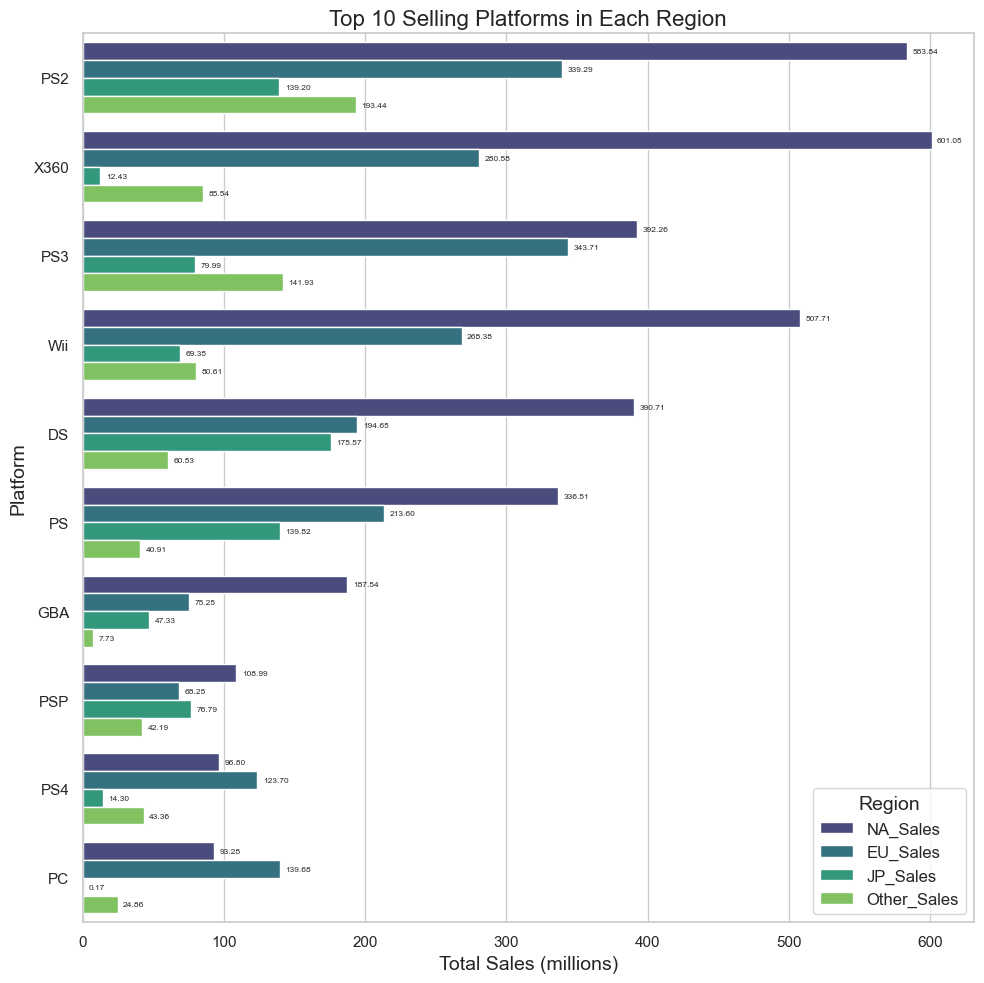

In [47]:
#Plotting the top 10 selling platforms in each region
platform_sales = vgsales.groupby('Platform').agg({'NA_Sales': 'sum','EU_Sales': 'sum','JP_Sales': 'sum','Other_Sales': 'sum'}).reset_index()
platform_sales['Total'] = platform_sales[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum(axis=1)
top_10_platforms = platform_sales.nlargest(10, 'Total')


# Melt the DataFrame to make it suitable for seaborn's barplot
platform_sales_melted = top_10_platforms.melt(id_vars='Platform',value_vars=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'],var_name='Region',value_name='Sales')

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 10))
ax = sns.barplot(data=platform_sales_melted, x='Sales', y='Platform', hue='Region', palette='viridis')

plt.title('Top 10 Selling Platforms in Each Region', fontsize=16)
plt.xlabel('Total Sales (millions)', fontsize=14)
plt.ylabel('Platform', fontsize=14)
plt.legend(title='Region', fontsize=12, title_fontsize=14)

for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", fontsize=6, padding=4,)

plt.tight_layout()
plt.show()

This graph goes onto illustrate the how when looking at specific regions, platforms sold more in certain regions than others. However all regions seem to increase in sales with each new platform when looked at individually. North America being the main source of revenue (Global Sale), this is forshadowing the high correlation that will be seen in a later section.

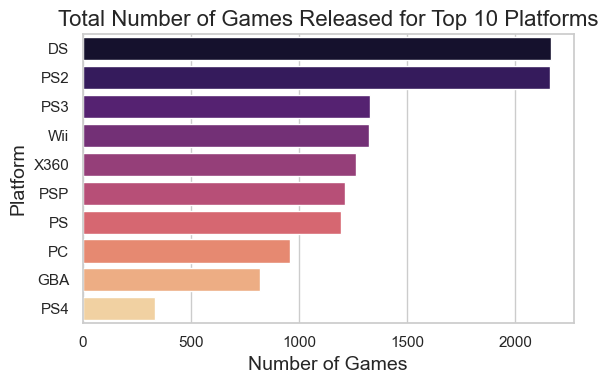

In [17]:
# Plotting the total number of games released for Top 10 platforms
platform_sales = vgsales.groupby('Platform').agg({'Global_Sales': 'sum'}).reset_index()

top_10_platforms = platform_sales.nlargest(10, 'Global_Sales')['Platform']

top_10_vgsales = vgsales[vgsales['Platform'].isin(top_10_platforms)]

platform_game_counts = top_10_vgsales['Platform'].value_counts().reset_index()
platform_game_counts.columns = ['Platform', 'Game Count']

ax = sns.set_theme(style="whitegrid")

plt.figure(figsize=(6, 4))
sns.barplot(data=platform_game_counts, x='Game Count', y='Platform', palette='magma', hue='Platform', legend=False)

plt.title('Total Number of Games Released for Top 10 Platforms', fontsize=16,)
plt.xlabel('Number of Games', fontsize=14)
plt.ylabel('Platform', fontsize=14)
plt.tight_layout()

plt.show()

While this graph doesn't add much to our analysis, it is extremely interesting seeing that while DS and PS2 almost match in the total number of games sold, the total sales each platform makes is drastically different. Returning back to the first graph, you can see that DS is the 5th highest selling platform. This illustrates that the number of games provided to a platform plays almost no impact on sales.

### Ranking 

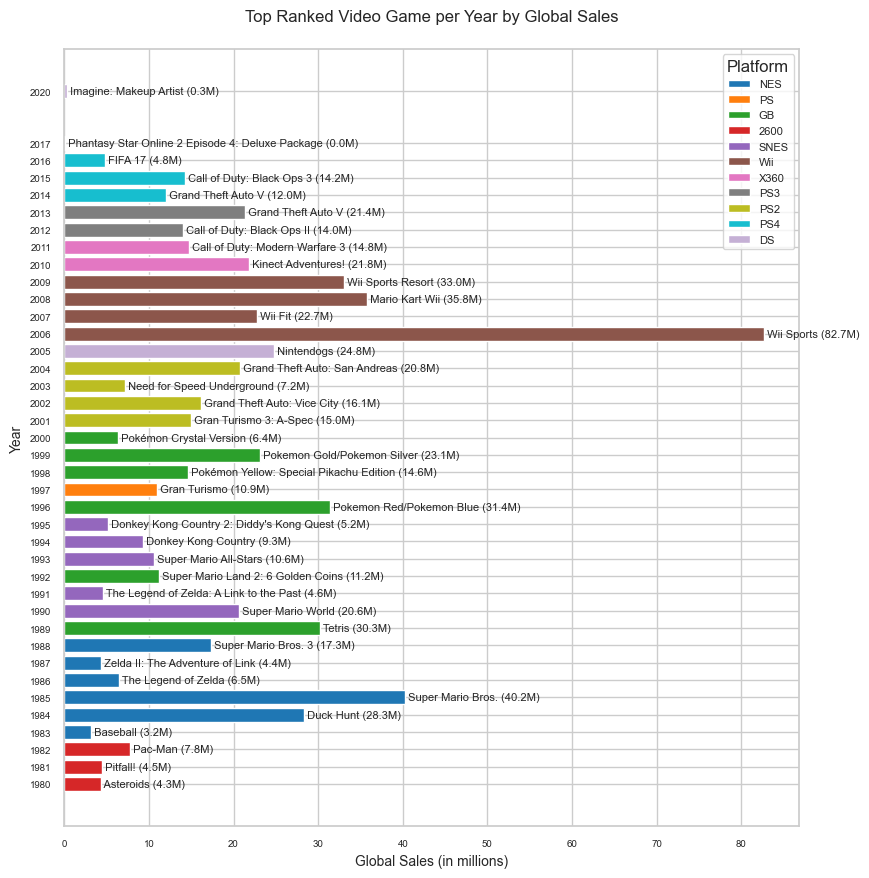

In [18]:

top_per_year = vgsales.loc[vgsales.groupby('Year')['Rank'].idxmin()]
top_per_year = top_per_year.sort_values(by='Year')

custom_colors = {
    'NES': '#1f77b4', 'PS': '#ff7f0e', 'GB': '#2ca02c', '2600': '#d62728',
    'SNES': '#9467bd', 'Wii': '#8c564b', 'X360': '#e377c2', 'PS3': '#7f7f7f',
    'PS2': '#bcbd22', 'PS4': '#17becf', 'DS': '#c5b0d5'
}

plt.figure(figsize=(9, 9))
ax = plt.gca()

bars = ax.barh(top_per_year['Year'], top_per_year['Global_Sales'], color=[custom_colors.get(color) for color in top_per_year['Platform']])

ax.set_yticks(top_per_year['Year'])
ax.set_xlabel('Global Sales (in millions)', fontsize=10)
ax.set_ylabel('Year', fontsize=10)
ax.set_title('Top Ranked Video Game per Year by Global Sales', fontsize=12, pad=20)

for i, bar in enumerate(bars):
    game = top_per_year.iloc[i]
    ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f" {game['Name']} ({game['Global_Sales']:.1f}M)", va='center', fontsize=8)

legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color,) for color in custom_colors.values()]
ax.legend(legend_elements, custom_colors.keys(), title="Platform", fontsize=8)

plt.tight_layout()
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()

While this graph goes on to list the top selling games in each year, it also shows that each platform has it moment of fame, that is until a new console takes its place. The Wii platform held the most sold game of the year for 4 years straight, selling more than any of its competitors with it's sports genre. Interestingly enough, despite the PS2 having the most global sales overall, none of its games were able to reach the levels Wii sports did.

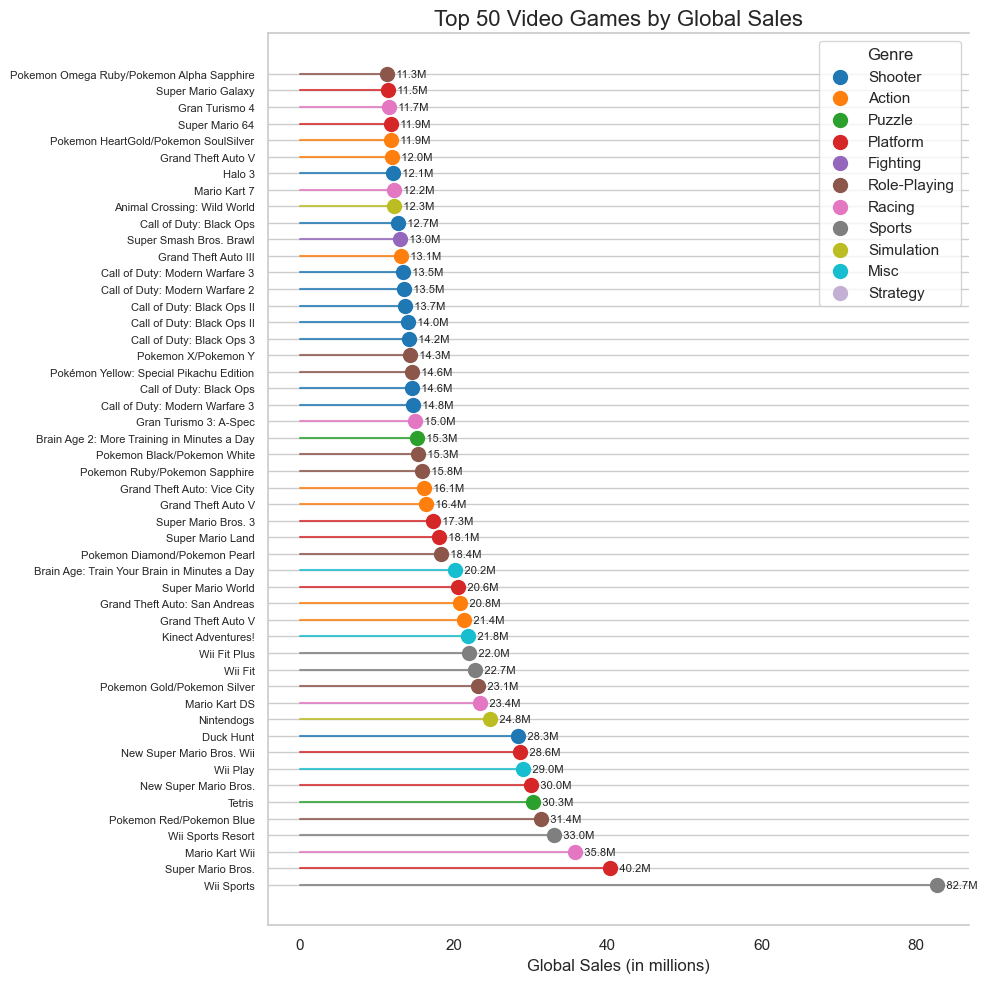

In [55]:
custom_colors_ = {
    'Shooter': '#1f77b4', 'Action': '#ff7f0e', 'Puzzle': '#2ca02c',
    'Platform': '#d62728', 'Fighting': '#9467bd', 'Role-Playing': '#8c564b',
    'Racing': '#e377c2', 'Sports': '#7f7f7f', 'Simulation': '#bcbd22',
    'Misc': '#17becf', 'Strategy': '#c5b0d5'
}
top_50_games = vgsales.sort_values(by='Global_Sales', ascending=False).head(50)

plt.figure(figsize=(10, 10))
ax = plt.gca()

for i, (index, row) in enumerate(top_50_games.iterrows()):
    plt.plot([0, row['Global_Sales']], [i, i], color=custom_colors_[row['Genre']], alpha=0.8)
    plt.scatter(row['Global_Sales'], i, s=100, color=custom_colors_[row['Genre']], zorder=2)

ax.set_yticks(range(len(top_50_games)))
ax.set_yticklabels(top_50_games['Name'], fontsize=8)
ax.set_xlabel('Global Sales (in millions)', fontsize=12)
ax.set_title('Top 50 Video Games by Global Sales', fontsize=16)
ax.spines['right'].set_visible(False)
ax.grid(axis='x')

legend_elements = [plt.scatter([], [], s=100, color=color, label=genre) for genre, color in custom_colors.items()]
ax.legend(handles=legend_elements, title='Genre') 

for i, (index, row) in enumerate(top_50_games.iterrows()):
    ax.text(row['Global_Sales'], i, f"   {row['Global_Sales']:.1f}M", va='center', fontsize=8)

plt.tight_layout()
plt.show()

### Publisher

C:\Users\Dave Maiullo\AppData\Local\Temp\ipykernel_21512\1265994783.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=publisher_sales_total_sorted, x='Publisher', y='Global_Sales', palette='Set2')


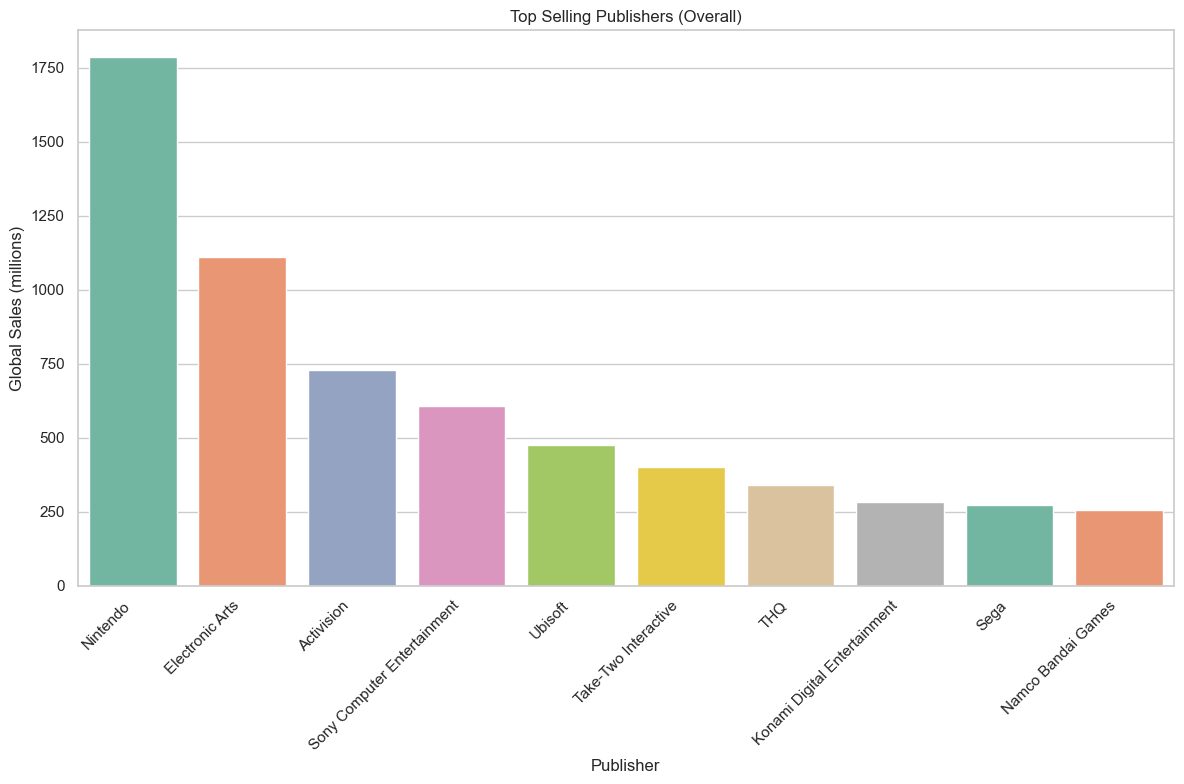

In [20]:
# Group by Publisher, summing up Global_Sales
publisher_sales_total = vgsales.groupby('Publisher')['Global_Sales'].sum().reset_index()

# Sort publishers by total global sales in descending order
publisher_sales_total_sorted = publisher_sales_total.sort_values(by='Global_Sales', ascending=False).head(10)  # Displaying top 10 publishers for clarity

# Set up the plot
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")  # Optional: Use seaborn styling

# Plotting
sns.barplot(data=publisher_sales_total_sorted, x='Publisher', y='Global_Sales', palette='Set2')

# Adding labels and title
plt.title('Top Selling Publishers (Overall)')
plt.xlabel('Publisher')
plt.ylabel('Global Sales (millions)')
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()


Nintendo takes the lead in top selling publisher. 

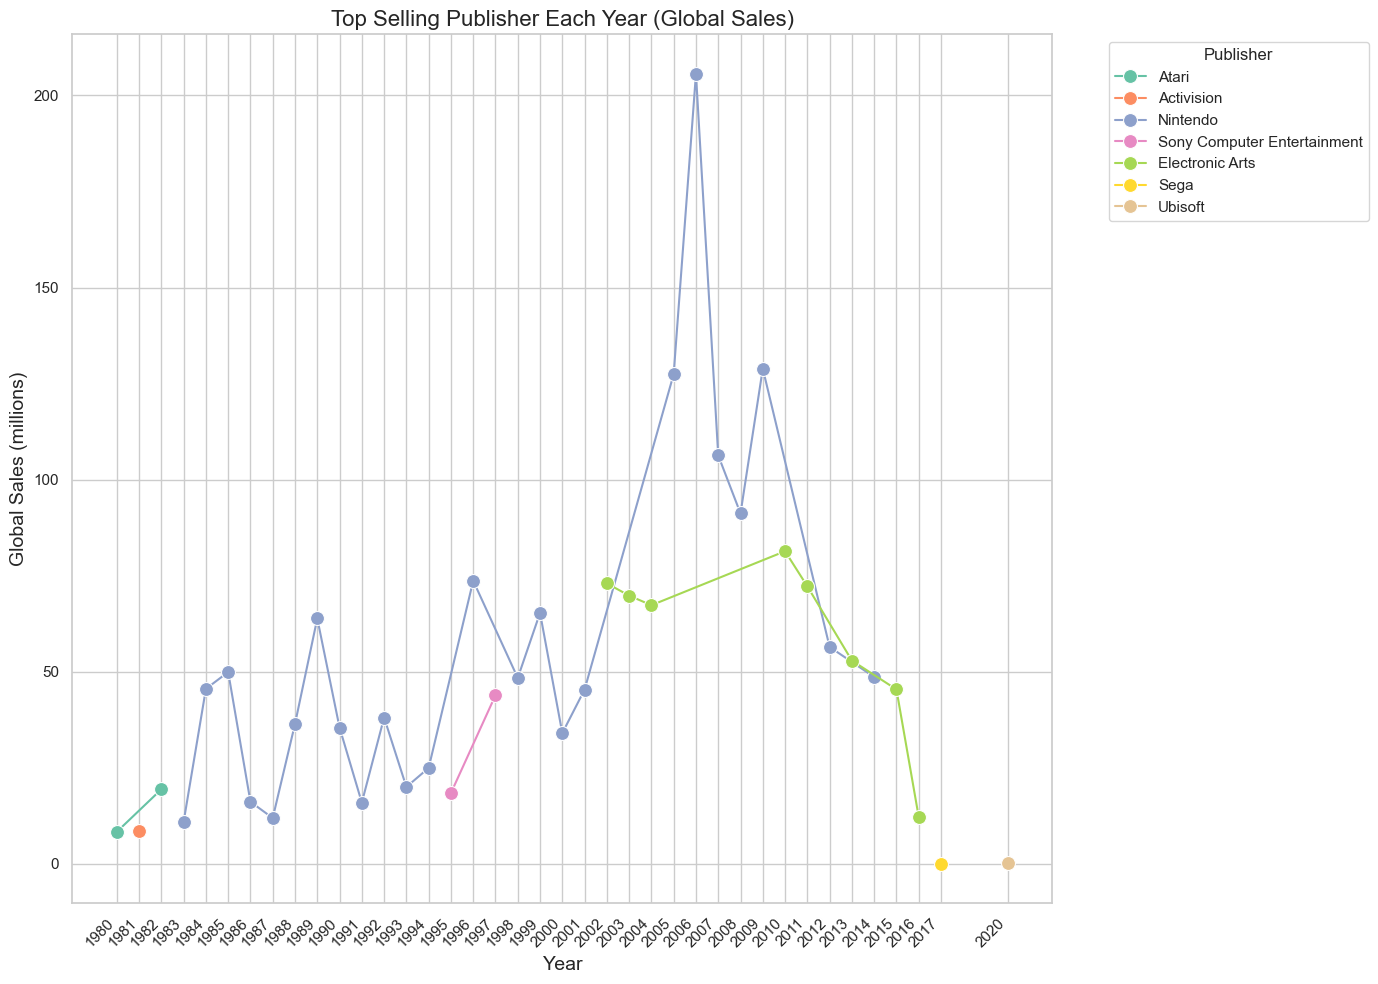

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by Year and Publisher, summing up Global_Sales
publisher_sales_year = vgsales.groupby(['Year', 'Publisher'])['Global_Sales'].sum().reset_index()

# Find the top selling publisher for each year
top_publishers_year = publisher_sales_year.loc[publisher_sales_year.groupby('Year')['Global_Sales'].idxmax()]

# Set up the plot
plt.figure(figsize=(14, 10))
sns.set(style="whitegrid")

# Plotting with a wider figure and increased marker size
sns.lineplot(data=top_publishers_year, x='Year', y='Global_Sales', hue='Publisher', marker='o', markersize=10, palette='Set2')

# Adding labels and title
plt.title('Top Selling Publisher Each Year (Global Sales)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Global Sales (millions)', fontsize=14)
plt.xticks(top_publishers_year['Year'].unique())
plt.legend(title='Publisher', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')


# Adjusting layout for better visibility
plt.tight_layout()
plt.show()


With Nintendo having a clear streak over the years

## Data Preprocessing

In order to make predictions with this data, we have to find what has the highest correlation with our target value (Global Sales). The higher the correlation is the more of an impact those variables have on Global Sales. These variables will be the leveraged for our models, increasing the accuracy of our predictions. 

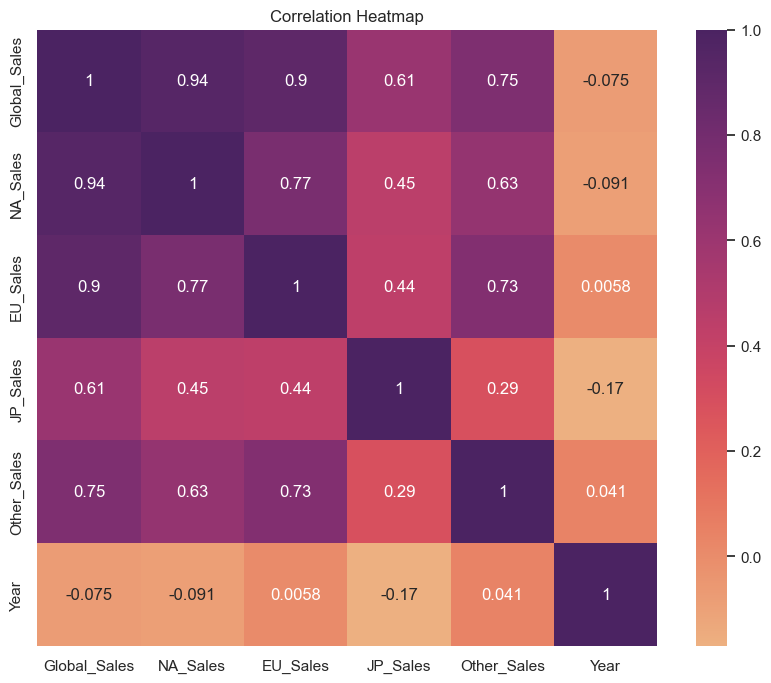

In [22]:
#Making a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(vgsales[['Global_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', "Year",]].corr(), annot=True, cmap='flare')
plt.title('Correlation Heatmap')
plt.show()


The main values that have the highest correlation to our target value (Global Sales) is NA_Sales, with other regions following close behind. This is follows suit considering the sales vales seen in the Data Exploration section of this project. On the other side of the spectrum, the values of the year seem to have almost no correlation at all. 

### What to do with Categorical Data

Although we now know what values will be useful in predicting our data, we need to know what data ISNT going to be useful. an example of data that may not be useful to process for training is our categorical data we have from our other remaining columns

In [23]:
# Printing out the unique value amount in each column
cat_cols = [col for col in vgsales.columns if vgsales[col].dtype=='object']
object_nunique = {col: vgsales[col].nunique() for col in cat_cols}
sorted_nunique = sorted(object_nunique.items(), key=lambda x: x[1])
print(sorted_nunique)


[('Genre', 12), ('Platform', 31), ('Publisher', 578), ('Name', 11493)]


BUT because there are so many unique values for our categorical columns, converting them to be used in the data would prove extremely difficult, so they will be avoided.

### Removal of the Year

Although the year column was useful for our data exploration, it is not needed for the training, because its correlation is so low. 

In [24]:
vgsales_prep = vgsales.drop(columns=["Year"]).copy()

## Data Processing 

### Data Splitting

Now that we have dropped our essentially useless column, we can start to split our data into the Training, Valid, and Test Data. As well as the data processing for our models.

We are going to use three different models, XGBRegressor, DecisionTreeRegressor, and RandomForestRegressor, and see which has the lowest Mean Absolute Error (MAE). The reasoning behind this that MAE acts as an interpretation of the average prediction error, hence the lower the less error being made in our predictions when compared to the valid dataset. 

In [25]:
# How we will split the data
from sklearn.model_selection import train_test_split

# How we will tell which of our predictions performs the best
from sklearn.metrics import mean_absolute_error

# 1/3 of the models we will be using
from sklearn.tree import DecisionTreeRegressor

In [26]:
# The features we are going to be using for our Training
features = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

# Then we are going to split our data
X = vgsales_prep[features].astype(str)
y = vgsales_prep['Global_Sales']

# Now we can set up the split
# A test size of 0.25 will give you 25% for validation and 75% for training
train_X, valid_X, train_y, valid_y = train_test_split(X,y,test_size=0.25,random_state=1)

print("TYPE" ,type(valid_X))



TYPE <class 'pandas.core.frame.DataFrame'>


### Messing with Models

##### DecisionTreeRegressor

In [27]:
# Our first model test
model_DT = DecisionTreeRegressor(random_state=2)

# Fit our training data on the model
model_DT.fit(train_X,train_y)

DecisionTreeRegressor(random_state=2)

In [28]:
# Lets make a dataframe to hold the values of each model 
col = {
    'MAE': pd.Series([0,0,0], dtype='float64')
}

regre = ['DecisionTreeRegressor','RandomForestRegressor','XGBRegressor']

results = pd.DataFrame(col,index=regre)
print(results)

                       MAE
DecisionTreeRegressor  NaN
RandomForestRegressor  NaN
XGBRegressor           NaN


In [29]:
# Time to make the first prediction
prediction_DT = model_DT.predict(valid_X)

# Calculating the MAE (error) by comparing the predicted value with the unknown data (valid data)
mae_DT = mean_absolute_error(prediction_DT, valid_y)


results.iloc[0] = float(mae_DT)
results


,MAE
DecisionTreeRegressor,0.054456
RandomForestRegressor,NaN
XGBRegressor,NaN


##### RandomForestRegressor

In [30]:
#Now to try the other models
from sklearn.ensemble import RandomForestRegressor

model_RFR = RandomForestRegressor(random_state=2)

model_RFR.fit(train_X,train_y)


RandomForestRegressor(random_state=2)

In [31]:
prediction_RFR = model_RFR.predict(valid_X)
mae_RFR = mean_absolute_error(prediction_RFR, valid_y)
results.iloc[1] = float(mae_RFR)
results

,MAE
DecisionTreeRegressor,0.054456
RandomForestRegressor,0.020973
XGBRegressor,NaN


##### XGBRegressor

In [32]:
# Now time for the final model
from xgboost import XGBRegressor

#weird error came up saying that train_X wasn't of an approraite type.
train_X = train_X.astype(float)

model_XGB = XGBRegressor(random_state=2)
model_XGB.fit(train_X,train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=2, ...)

In [33]:
#odd issue, doesn't accept valid_X
valid_X = valid_X.astype(float)

prediction_XGB = model_XGB.predict(valid_X)
mae_XGB = mean_absolute_error(prediction_XGB, valid_y)
results.iloc[2] = float(mae_XGB)
results

,MAE
DecisionTreeRegressor,0.054456
RandomForestRegressor,0.020973
XGBRegressor,0.033623


With these results it seems that the RandomForestRegressor has the best MAE since the lower the score, the better the model's performance in terms of accuracy. We could go and move on with this information but instead we will try to make our tests a little more robust by doing Cross Validation of the three models.

In [34]:
def scatter_plot(prediction, Model_name):
    errors  = np.abs(prediction - valid_y)
    plt.figure(figsize=(9, 6))
    plt.scatter(np.ones_like(errors), errors, c='blue', alpha=0.5, zorder=2, label='Errors')
    plt.scatter(2 * np.ones_like(prediction), prediction, c='green', alpha=0.5, zorder=2, label='Predictions')
    plt.scatter(3 * np.ones_like(valid_y), valid_y, c='red', alpha=0.5, zorder=2, label='Actual Data')

    plt.title(Model_name + ': Errors, Predictions, and Actual Data')
    plt.ylabel('Global Sales')
    plt.xticks([1, 2, 3], ['Errors', 'Predictions', 'Actual Data'])
    plt.xlim(0.5, 3.5)
    plt.ylim(-3, 90)
    
    plt.legend(loc='upper left')
    plt.show()

##### Attempt to Graph Errors vs Predictions vs Actual Data


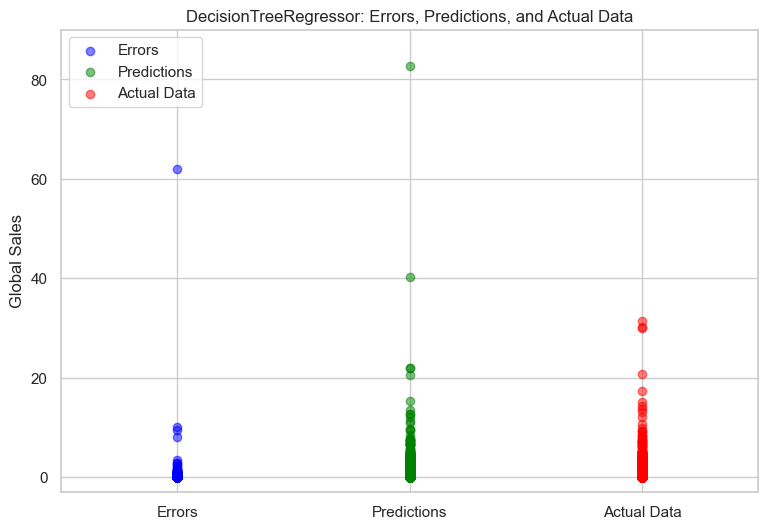

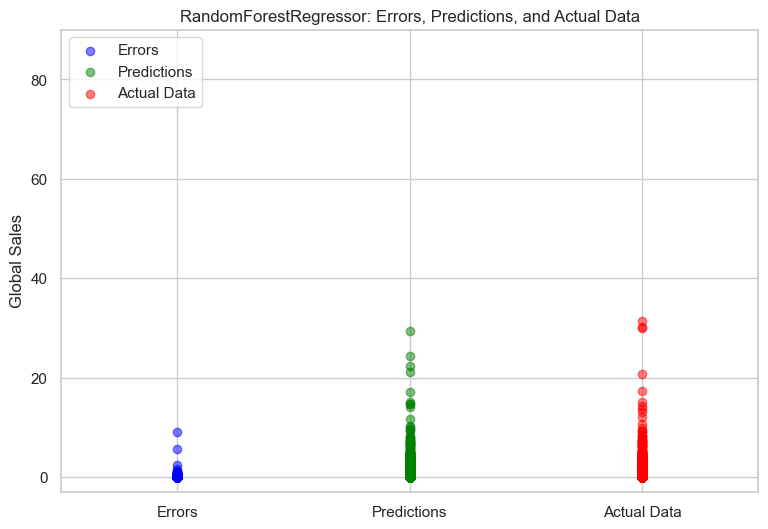

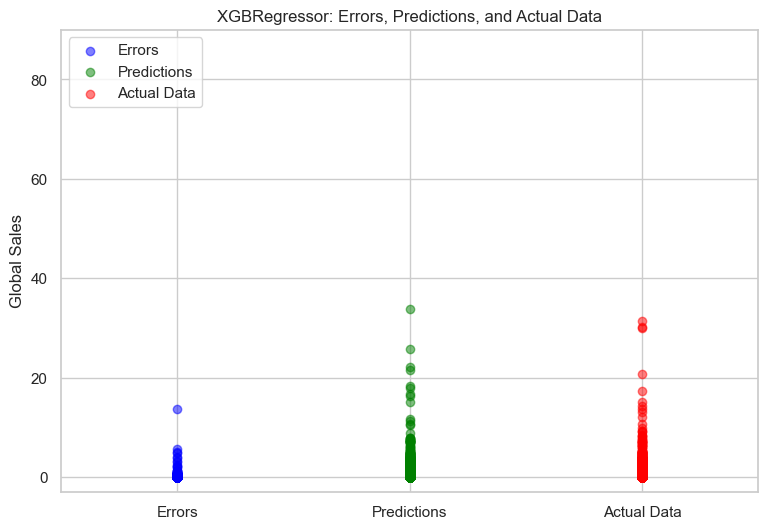

In [35]:
scatter_plot(prediction_DT, 'DecisionTreeRegressor')
scatter_plot(prediction_RFR, 'RandomForestRegressor')
scatter_plot(prediction_XGB, 'XGBRegressor')


These diagrams provide a visual representation of each model's performance from our initial run through. The 'Errors' column shows the absolute differences between predicted and actual sales values. The spacing between these error points indicates the magnitude of prediction inaccuracies ( the wider apart, the larger error, the exact same as MAE). As was demonstrated by the Mean Absolute Error (MAE) results, the Random Forest Regression model appears to have the smallest error margin. 

### Cross Validation

Cross vailation is the process of divding our data into multiple sections, or folds are they are typically referred to as, where one section acts as the validation set and the rest as the training set, which is then ran through our models. Different combinations of validation and training sets are made based on the number of folds had. With these multiple sets of data being ran through our models, it helps in producing a more robust estimate of each model's performance.

In [37]:
from sklearn.model_selection import cross_val_score
# Running each Cross Validation with cv 5
scores_DT = -cross_val_score(model_DT,X,y,cv=5,scoring='neg_mean_absolute_error')
scores_RFR = -cross_val_score(model_RFR,X,y,cv=5,scoring='neg_mean_absolute_error')

X = X.astype(float)

scores_XGB = -cross_val_score(model_XGB,X,y,cv=5,scoring='neg_mean_absolute_error')

results['Mean_MAE'] = [scores_DT.mean(), scores_RFR.mean(), scores_XGB.mean()]
results['Std_MAE'] = [scores_DT.std(), scores_RFR.std(), scores_XGB.mean()]
results

,MAE,Mean_MAE,Std_MAE
DecisionTreeRegressor,0.054456,0.336613,0.538114
RandomForestRegressor,0.020973,0.324417,0.545318
XGBRegressor,0.033623,0.301442,0.301442


After running the cross validation our values go up by a decent amount. Originally it was seen that RandomForestRegressor(RFR) was the best performer with only having .02 sales error off, but after running the multiple folds of Cross Validation, it seems that XGBRegressor is taking the lead with having the lowest Mean and Standard Deviation. This means that (within our tests) XGB proves more consistent over multiple splits than RFR.

In [38]:
# Running each Cross Validation with cv 15
scores_DT = -cross_val_score(model_DT,X,y,cv=15,scoring='neg_mean_absolute_error')
scores_RFR = -cross_val_score(model_RFR,X,y,cv=15,scoring='neg_mean_absolute_error')
scores_XGB = -cross_val_score(model_XGB,X,y,cv=15,scoring='neg_mean_absolute_error')

results['Mean_MAE2'] = [scores_DT.mean(), scores_RFR.mean(), scores_XGB.mean()]
results['Std_MAE2'] = [scores_DT.std(), scores_RFR.std(), scores_XGB.mean()]
results



,MAE,Mean_MAE,Std_MAE,Mean_MAE2,Std_MAE2
DecisionTreeRegressor,0.054456,0.336613,0.538114,0.209205,0.599649
RandomForestRegressor,0.020973,0.324417,0.545318,0.193969,0.604471
XGBRegressor,0.033623,0.301442,0.301442,0.176231,0.176231


As more folds are added, XGB continues to outperform the other models. While RFR dropped in its Mean, it noticably increased in the Standard Deviation by 0.059153. DTR on the other hand had a decrease in its Mean, and an increase in its Standard deviation. Unlike that other models, XGB's values decreased in both the Mean and Standard Deviation, significant reductions in error.

Although Cross Validation gave us a good look at what may be the better option, lets take a look at another method for narrowing down our options

### Hyper Parameter Tuning

With HPT (HyperParameterTuning) you are essentially just adding specifications to the models themselves to see if you can push the results more towards optimization. The bonus is the manual ability to tweak everything, the downside is also the manual ability to tweak everything... Luckily that is why something like GridSearch exists, which is what will help find the better tunes to use for us

In [40]:
from sklearn.model_selection import GridSearchCV

#we are first going to try this with DT

#creating a parameter grid
pg_DT = {
    'max_depth': [None,10,20,30],
    'min_samples_split': [5,10,20],
    'min_samples_leaf': [1,2,4],
}

grid_search_DT = GridSearchCV(
    estimator=model_DT,
    param_grid=pg_DT,
    cv=15,
    scoring='neg_mean_absolute_error',
    verbose=1
    )

grid_search_DT.fit(X,y)
best_model_DT = grid_search_DT.best_estimator_
predictions_DT = best_model_DT.predict(valid_X)
mae_DT_HPT = mean_absolute_error(predictions_DT, valid_y)

Fitting 15 folds for each of 36 candidates, totalling 540 fits


In [41]:
mae_DT_HPT

np.float64(0.010923614797671819)

With those HPT alone we were able to get a MAE of 0.0109 for DT which is a significant drop from even our lowest MAE previously for DT. and it seems that our parameters we chose were also already good. Meaning I see no need to change it, even though it took little to no time to process

In [42]:
best_model_DT

DecisionTreeRegressor(min_samples_split=5, random_state=2)

Now it is time to run similar tests on the other models and then save them in the DataFrame

In [46]:

#creating a parameter grid for RFR this time
#basically the same besides adding the n estimators.
pg_RFR = {
    'max_depth': [None,10,20,30],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'n_estimators': [66, 73, 81],
}

grid_search_RFR = GridSearchCV(
    estimator=model_RFR,
    param_grid=pg_RFR,
    cv=15,
    scoring='neg_mean_absolute_error',
    verbose=1
    )

grid_search_RFR.fit(X,y)
best_model_RFR = grid_search_RFR.best_estimator_
predictions_RFR = best_model_RFR.predict(valid_X)
mae_RFR_HPT = mean_absolute_error(predictions_RFR, valid_y)

Fitting 15 folds for each of 108 candidates, totalling 1620 fits


KeyboardInterrupt: 

*be weary, the above code took 5m45.6s to compute*

In [42]:
best_model_RFR

RandomForestRegressor(max_depth=20, n_estimators=103, random_state=2)

In [43]:
mae_RFR_HPT

np.float64(0.008058043807064253)

In [50]:
#we are first going to try this with DT

#creating a parameter grid
pg_XGB = {
    'max_depth': [None,10,20,30],
    'learning_rate': [0.01, 0.1, 0.3],
    'reg_alpha': [0,0.1,0.5],
    'reg_lambda': [0,0.1,0.5],
}

grid_search_XGB = GridSearchCV(
    estimator=model_XGB,
    param_grid=pg_XGB,
    cv=15,
    scoring='neg_mean_absolute_error',
    verbose=1
    )

grid_search_XGB.fit(X,y)
best_model_XGB = grid_search_XGB.best_estimator_
predictions_XGB = best_model_XGB.predict(valid_X)
mae_XGB_HPT = mean_absolute_error(predictions_XGB, valid_y)

Fitting 15 folds for each of 108 candidates, totalling 1620 fits


In [51]:
best_model_XGB

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=2, ...)

In [52]:
mae_XGB_HPT

np.float64(0.009377912238365916)

*be weary, the above code took 6m47.6s to compute*

In [44]:
#putting our results into a DataFrame
results['MAE_HPT'] = [mae_DT_HPT, mae_RFR_HPT, mae_XGB_HPT]
results

NameError: name 'mae_RFR_HPT' is not defined

After messing around with HPT for awhile, The results we have gotten are quite adequate. Although there is likely a way to get the numbers even lower- having the numbers for sales be this low with tuning is almost good enough to not be worried about.

Although the RFR has the lower value for the HPT, we will be choosing XGB as the final model due to the fact it performed overall best in multiple categories besides the final. AND if it performed better in the previous categories it likely can be tuned further to perform even better. One would just need to find out that tuning.

## Final Model : XGBRegressor

Now that we have chosen our final model(XGBRegressor), we are going to run it through all of the steps again

In [ ]:

#Giving the final model its rightful name and throne
final_model = XGBRegressor(
    max_depth=best_model_XGB.max_depth,
    learning_rate=best_model_XGB.learning_rate,
    reg_alpha=best_model_XGB.reg_alpha,
    reg_lambda=best_model_XGB.reg_lambda,
    n_estimators=best_model_XGB.n_estimators,
    random_state=2,
)

#fitting the model
final_model.fit(train_X,train_y)

#Run it on the validation set
final_predictions = final_model.predict(valid_X)
final_mae = mean_absolute_error(valid_y, final_predictions)

#turning our nice little values into a dataframe for all to see!!
# finaldata = {
#     'final_MAE': [final_mae],
#     'HPT_XGB_MAE': [mae_XGB_HPT],
# }
# anIndex = ['XGBRegressor']
# actually I am quite sure this would just block the other stuff from being printed
print(f'Final MAE on Validation Set: {final_mae:.6f}')
print(f'Hyper-Tuned XGB MAE: {mae_XGB_HPT:.6f}')


# A scatter plot comparing the actual game sales with the predicted game sales
plt.figure(figsize=(10, 6))
plt.scatter(valid_y, final_predictions, alpha=0.3)
plt.plot([valid_y.min(), valid_y.max()], [valid_y.min(), valid_y.max()], '--r', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Global Sales')
plt.show()

# Looking at the features that were the most important,
# Although we didnt have many
important = final_model.feature_importances_
feat = train_X.columns
important_final = pd.DataFrame({'Feature': feat, 'Importance': important})
important_final = important_final.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance',y="Feature", data=important_final)
plt.title("Important Features")
plt.show()

print("Summary and Conclusion:")
print(f"The final model, XGBRegressor, has been trained and evaluated.")
print(f"Mean Absolute Error (MAE) on the validation set: {final_mae:.6f}")
print("The feature importance plot shows the most significant features contributing to the model's predictions.")
print("The model demonstrates good performance and generalizes well on the validation set, indicating it is a suitable fit for predicting global sales.")

NameError: name 'best_model_XGB' is not defined